In [ ]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Conv1D, GlobalMaxPooling1D, concatenate, Input, Attention
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Model
from keras.layers import Input, Embedding, Conv1D, GlobalMaxPooling1D, LSTM, Dense, Dropout, Bidirectional, TimeDistributed, Flatten, concatenate
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder

In [2]:
df = pd.read_csv('clean_data.csv')
df

,label,msg
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,1,This is the 2nd time we have tried 2 contact u...
5568,0,Will Ì_ b going to esplanade fr home?
5569,0,"Pity, * was in mood for that. So...any other s..."
5570,0,The guy did some bitching but I acted like i'd...


In [ ]:
text_data = df['msg']
labels = df['label']

# Local Feature Extraction (CNN)
def extract_cnn_features(texts):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(texts)
    sequences = tokenizer.texts_to_sequences(texts)
    padded_sequences = pad_sequences(sequences, maxlen=50)  # Adjust maxlen as needed

    model_cnn = Sequential()
    model_cnn.add(Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=50, input_length=50))
    model_cnn.add(Conv1D(64, kernel_size=3, activation='relu'))
    model_cnn.add(GlobalMaxPooling1D())
    cnn_features = model_cnn.predict(padded_sequences)
    return cnn_features

# Temporal Feature Extraction (LSTM)
def extract_lstm_features(texts):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(texts)
    sequences = tokenizer.texts_to_sequences(texts)
    padded_sequences = pad_sequences(sequences, maxlen=50)  # Adjust maxlen as needed

    model_lstm = Sequential()
    model_lstm.add(Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=50, input_length=50))
    model_lstm.add(LSTM(64, dropout=0.2))
    lstm_features = model_lstm.predict(padded_sequences)
    return lstm_features

# Global Feature Extraction (TF-IDF)
def extract_tfidf_features(texts):
    vectorizer = TfidfVectorizer()
    tfidf_features = vectorizer.fit_transform(texts)
    return tfidf_features.toarray()

In [ ]:
# Feature extraction for each data point
print("Extracting local features")
cnn_features = extract_cnn_features(text_data)

print("\nExtracting temporal features")
lstm_features = extract_lstm_features(text_data)

print("\nExtracting global features")
tfidf_features = extract_tfidf_features(text_data)

# Feature Fusion
print("\nData fusion")
concatenated_features = np.concatenate([cnn_features, lstm_features, tfidf_features], axis=1)

Extracting local features
175/175 [==============================] - 0s 1ms/step

Extracting temporal features
175/175 [==============================] - 2s 7ms/step

Extracting global features

Data fusion


In [ ]:
concatenated_features.shape

(5572, 8800)

In [ ]:
X = concatenated_features
y = labels

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Attention Mechanism
input_layer = Input(shape=(concatenated_features.shape[1],))
attention_probs = Dense(concatenated_features.shape[1], activation='softmax', name='attention_probs')(input_layer)
attention_mul = concatenate([input_layer, attention_probs], name='attention_mul')

# Classifier
output_layer = Dense(32, activation='relu')(attention_mul)
output_layer = Dense(1, activation='sigmoid')(output_layer)

# Model
model = Model(inputs=input_layer, outputs=output_layer)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
print("\nTrain the classification model")
model.fit(X_train, y_train, validation_data= (X_test, y_test), epochs=10)


Train the classification model
Epoch 1/10
140/140 [==============================] - 69s 490ms/step - loss: 0.4094 - accuracy: 0.8636 - val_loss: 0.2968 - val_accuracy: 0.8655
Epoch 2/10
140/140 [==============================] - 67s 482ms/step - loss: 0.2255 - accuracy: 0.8661 - val_loss: 0.1968 - val_accuracy: 0.8655
Epoch 3/10
140/140 [==============================] - 67s 479ms/step - loss: 0.1367 - accuracy: 0.9477 - val_loss: 0.1211 - val_accuracy: 0.9677
Epoch 4/10
140/140 [==============================] - 67s 477ms/step - loss: 0.0677 - accuracy: 0.9895 - val_loss: 0.0845 - val_accuracy: 0.9776
Epoch 5/10
140/140 [==============================] - 67s 477ms/step - loss: 0.0393 - accuracy: 0.9942 - val_loss: 0.0714 - val_accuracy: 0.9794
Epoch 6/10
140/140 [==============================] - 64s 459ms/step - loss: 0.0260 - accuracy: 0.9955 - val_loss: 0.0644 - val_accuracy: 0.9812
Epoch 7/10
140/140 [==============================] - 65s 461ms/step - loss: 0.0183 - accuracy: 0.

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt 
import seaborn as sns

print('Classification report for the classification model')

y_pred = model.predict(X_test).round()

print(classification_report(y_test, y_pred))

Classification report for the classification model
35/35 [==============================] - 1s 23ms/step
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       965
           1       0.99      0.86      0.92       150

    accuracy                           0.98      1115
   macro avg       0.99      0.93      0.96      1115
weighted avg       0.98      0.98      0.98      1115



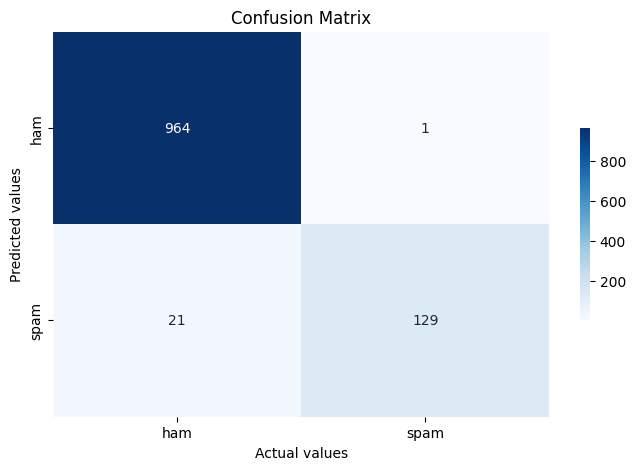

In [ ]:
# Confusion matrix of MNB model
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8,5))
axis_labels = ['ham', 'spam']
g = sns.heatmap(data=cm, annot=True, cmap="Blues", xticklabels=axis_labels, yticklabels=axis_labels, fmt='g', cbar_kws={"shrink": 0.5})
p = plt.xlabel('Actual values')
p = plt.ylabel('Predicted values')
p = plt.title('Confusion Matrix')